In [1]:
#!/usr/bin/env python
# coding: utf-8

import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import json
import time

import seisbench.models as sbm
import seisbench.data as sbd
import seisbench.generate as sbg

from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks



In [2]:
print("✓ All imports successful!")

✓ All imports successful!


In [3]:
# Load configuration from JSON file
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print("✓ Configuration loaded successfully!")
except FileNotFoundError:
    print("✗ Error: config.json file not found!")
    raise
except json.JSONDecodeError as e:
    print(f"✗ Error: Invalid JSON in config.json: {e}")
    raise
except Exception as e:
    print(f"✗ Unexpected error loading config: {e}")
    raise

✓ Configuration loaded successfully!


In [4]:
config

{'peak_detection': {'sampling_rate': 100, 'height': 0.5, 'distance': 100},
 'training': {'batch_size': 64,
  'num_workers': 4,
  'learning_rate': 0.01,
  'epochs': 50,
  'patience': 5,
  'loss_weights': [0.01, 0.4, 0.59],
  'optimization': {'mixed_precision': True,
   'gradient_accumulation_steps': 1,
   'pin_memory': True,
   'prefetch_factor': 2,
   'persistent_workers': True}},
 'device': {'use_cuda': True, 'device_id': 0}}

In [5]:
# Set random seed for reproducibility
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [6]:
import os

# Loader the picker
try:
    #model = sbm.EQTransformer.from_pretrained("original")
    model = sbm.PhaseNet.from_pretrained("stead")
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    raise

✓ Model loaded successfully!


In [7]:
# Set up device
device = torch.device(f"cuda:{config['device']['device_id']}" if torch.cuda.is_available() and config['device']['use_cuda'] else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [8]:
# Print PhaseNet model information
phasenet_total_params = sum(p.numel() for p in model.parameters())
phasenet_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("PhaseNet information:")
print(f"Total parameters: {phasenet_total_params:,}")
print(f"Trainable parameters: {phasenet_trainable_params:,}")
print(f"Model size: {phasenet_total_params * 4 / (1024**2):.2f} MB (float32)")

PhaseNet information:
Total parameters: 268,443
Trainable parameters: 268,443
Model size: 1.02 MB (float32)


In [9]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")# Display all PhaseNet model parameters with their names and shapes
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

inc.weight: torch.Size([8, 3, 7])
inc.bias: torch.Size([8])
in_bn.weight: torch.Size([8])
in_bn.bias: torch.Size([8])
down_branch.0.0.weight: torch.Size([8, 8, 7])
down_branch.0.1.weight: torch.Size([8])
down_branch.0.1.bias: torch.Size([8])
down_branch.0.2.weight: torch.Size([8, 8, 7])
down_branch.0.3.weight: torch.Size([8])
down_branch.0.3.bias: torch.Size([8])
down_branch.1.0.weight: torch.Size([16, 8, 7])
down_branch.1.1.weight: torch.Size([16])
down_branch.1.1.bias: torch.Size([16])
down_branch.1.2.weight: torch.Size([16, 16, 7])
down_branch.1.3.weight: torch.Size([16])
down_branch.1.3.bias: torch.Size([16])
down_branch.2.0.weight: torch.Size([32, 16, 7])
down_branch.2.1.weight: torch.Size([32])
down_branch.2.1.bias: torch.Size([32])
down_branch.2.2.weight: torch.Size([32, 32, 7])
down_branch.2.3.weight: torch.Size([32])
down_branch.2.3.bias: torch.Size([32])
down_branch.3.0.weight: torch.Size([64, 32, 7])
down_branch.3.1.weight: torch.Size([64])
down_branch.3.1.bias: torch.Size([

In [10]:
# Import XiaoNet from models
import sys
import os

# Add project root to path (works from any location)
# This notebook is in archive/, so go up one level to get to project root
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#from models.xn_xiao_net_v2 import XiaoNet
from models.xn_xiao_net_v2 import XiaoNet

# Create XiaoNet model
xiao_net = XiaoNet(
    window_len=3001,      # Match the data window length
    in_channels=3,        # 3 channels (E, N, Z)
    num_phases=3,         # 3 outputs (P, S, noise)
    base_channels=16      # Base channel width (can adjust for size)
)
xiao_net.to(device)

# Count parameters
total_params = sum(p.numel() for p in xiao_net.parameters())
trainable_params = sum(p.numel() for p in xiao_net.parameters() if p.requires_grad)

print(f"✓ XiaoNet created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")
print(f"Base channels: 16")
print(f"Kernel size: 3 (all convolution layers)")

✓ XiaoNet created successfully!
Total parameters: 151,619
Trainable parameters: 151,619
Model size: 0.58 MB (float32)
Base channels: 16
Kernel size: 3 (all convolution layers)


In [11]:
xiao_net.to(device)

XiaoNet(
  (enc1): Sequential(
    (0): Conv1d(3, 16, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv1d(64, 128, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (dec3): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(7,), stride=(4,), p

In [12]:
# Test XiaoNet forward pass with 3001 input to debug dimension flow
import importlib
import sys

# Remove old module from cache if it exists
if 'models.xn_xiao_net_v2' in sys.modules:
    del sys.modules['models.xn_xiao_net_v2']

if 'models.xn_xiao_net_v2' in sys.modules:
    del sys.modules['models.xn_xiao_net_v2']    

# Re-import with fresh code
#from models.xn_xiao_net_v2 import XiaoNet
from models.xn_xiao_net_v2 import XiaoNet

# Create XiaoNet model with fixed forward pass
xiao_net = XiaoNet(
    window_len=3001,      # Match the data window length
    in_channels=3,        # 3 channels (E, N, Z)
    num_phases=3,         # 3 outputs (P, S, noise)
    base_channels=16      # Base channel width (can adjust for size)
)
xiao_net.to(device)

# Test with a dummy batch to verify dimensions
test_input = torch.randn(2, 3, 3001).to(device)
try:
    test_output = xiao_net(test_input)
    print(f"✓ XiaoNet forward pass successful!")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
except Exception as e:
    print(f"✗ Error during forward pass: {e}")
    raise

# Count parameters
total_params = sum(p.numel() for p in xiao_net.parameters())
trainable_params = sum(p.numel() for p in xiao_net.parameters() if p.requires_grad)

print(f"\n✓ XiaoNet reloaded with fixed forward pass!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")
print(f"Base channels: 16")
print(f"Kernel size: 3 (all convolution layers)")


✓ XiaoNet forward pass successful!
  Input shape: torch.Size([2, 3, 3001])
  Output shape: torch.Size([2, 3, 3001])

✓ XiaoNet reloaded with fixed forward pass!
Total parameters: 151,619
Trainable parameters: 151,619
Model size: 0.58 MB (float32)
Base channels: 16
Kernel size: 3 (all convolution layers)


In [13]:
# Load the data
print("Loading data...")
try:
    data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")
    print("✓ Data loaded successfully!")

except Exception as e:

    print(f"✗ Error loading data: {e}")
    raise

Loading data...
✓ Data loaded successfully!


In [14]:
# Create a random sample
sample_fraction = 0.01  # Sample 20% of the data
print(f"Creating random sample of {sample_fraction*100}% of the data...")

Creating random sample of 1.0% of the data...


In [15]:
# Create a random mask for sampling
np.random.seed(42)  # For reproducibility

mask = np.random.random(len(data)) < sample_fraction
data.filter(mask)

print(f"Sampled dataset size: {len(data)}")


Sampled dataset size: 11425


In [16]:
print("Sample metadata:")
data.metadata.head(20)

Sample metadata:


,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
72,72,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2023-09-11T10:04:26.195000Z,earthquake_local,"bucket0$53,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2023-09-11T1004262023-09-1...,,100,ZNE
128,128,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2023-10-15T03:02:11.464999Z,earthquake_local,"bucket0$97,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2023-10-15T0302112023-10-1...,,100,ZNE
205,205,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2023-11-29T04:45:18.075000Z,earthquake_local,"bucket5$28,:3,:12001",test,2V.TG11.EHE.EHN.EHZ.2023-11-29T0445182023-11-2...,,100,ZNE
208,208,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2023-11-30T00:58:44.934999Z,earthquake_local,"bucket0$153,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2023-11-30T0058442023-11-3...,,100,ZNE
821,821,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-08-03T03:22:28.699999Z,earthquake_local,"bucket0$593,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-08-03T0322282024-08-0...,,100,ZNE
1168,1168,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-22T01:22:46.300000Z,earthquake_local,"bucket0$825,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-22T0122462025-02-2...,,100,ZNE
1283,1283,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-22T09:21:49.520000Z,earthquake_local,"bucket0$900,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-22T0921492025-02-2...,,100,ZNE
1426,1426,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2025-02-23T05:12:21.400000Z,earthquake_local,"bucket0$994,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-23T0512212025-02-2...,,100,ZNE
1483,1483,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-25T08:31:55.840000Z,earthquake_local,"bucket1$5,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-25T0831552025-02-2...,,100,ZNE
1515,1515,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-25T20:56:11.610000Z,earthquake_local,"bucket1$27,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-25T2056112025-02-2...,,100,ZNE


In [17]:
# Split data
train, dev, test = data.train_dev_test()

In [18]:

print("Train:", train)
print("Dev:", dev)
print("Test:", test)


Train: OKLA_1Mil_120s_Ver_3 - 7989 traces
Dev: OKLA_1Mil_120s_Ver_3 - 1695 traces
Test: OKLA_1Mil_120s_Ver_3 - 1741 traces


In [19]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [20]:
# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

In [21]:
# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)


In [22]:
# Parameters for peak detection
sampling_rate = config['peak_detection']['sampling_rate']
height = config['peak_detection']['height']
distance = config['peak_detection']['distance']

batch_size = config['training']['batch_size']
num_workers = config['training']['num_workers']

In [23]:
print("=" * 60)
print("TRAINING CONFIGURATION SANITY CHECK")
print("=" * 60)

print("\n📊 Dataset Information:")
print(f"  Total dataset size: {len(data):,} samples")
print(f"  Training set: {len(train):,} samples")
print(f"  Validation set: {len(dev):,} samples")
print(f"  Test set: {len(test):,} samples")
print(f"  Sample fraction used: {sample_fraction*100}%")

print("\n🔧 Data Augmentation Pipeline:")
for i, aug in enumerate(augmentations, 1):
    print(f"  {i}. {aug.__class__.__name__}")
    if hasattr(aug, '__dict__'):
        relevant_attrs = {k: v for k, v in aug.__dict__.items() if not k.startswith('_')}
        for key, val in relevant_attrs.items():
            print(f"     - {key}: {val}")

print("\n🎯 Model Information:")
print(f"  Model type: {model.__class__.__name__}")
print(f"  Total parameters: {phasenet_total_params:,}")
print(f"  Trainable parameters: {phasenet_trainable_params:,}")
print(f"  Model size: {phasenet_total_params * 4 / (1024**2):.2f} MB")
print(f"  Device: {device}")

print("\n⚙️ Training Hyperparameters:")
print(f"  Batch size: {batch_size}")
print(f"  Number of workers: {num_workers}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Number of epochs: {config['training']['epochs']}")
print(f"  Patience (early stopping): {config['training']['patience']}")

print("\n📈 Peak Detection Parameters:")
print(f"  Sampling rate: {sampling_rate} Hz")
print(f"  Height threshold: {height}")
print(f"  Distance: {distance} samples")

print("\n🔬 Phase Dictionary:")
print(f"  P-phases: {len(p_phases)} types")
print(f"  S-phases: {len(s_phases)} types")

print("\n💾 Data Loader Configuration:")
print(f"  Pin memory: True")
print(f"  Prefetch factor: 4")
print(f"  Persistent workers: True")

print("\n" + "=" * 60)
print("Ready to start training!")
print("=" * 60)

TRAINING CONFIGURATION SANITY CHECK

📊 Dataset Information:
  Total dataset size: 11,425 samples
  Training set: 7,989 samples
  Validation set: 1,695 samples
  Test set: 1,741 samples
  Sample fraction used: 1.0%

🔧 Data Augmentation Pipeline:
  1. WindowAroundSample
     - metadata_keys: ['trace_p_arrival_sample', 'trace_pP_arrival_sample', 'trace_P_arrival_sample', 'trace_P1_arrival_sample', 'trace_Pg_arrival_sample', 'trace_Pn_arrival_sample', 'trace_PmP_arrival_sample', 'trace_pwP_arrival_sample', 'trace_pwPm_arrival_sample', 'trace_s_arrival_sample', 'trace_S_arrival_sample', 'trace_S1_arrival_sample', 'trace_Sg_arrival_sample', 'trace_SmS_arrival_sample', 'trace_Sn_arrival_sample']
     - samples_before: 3000
     - selection: random
     - p0: None
     - windowlen: 6000
     - strategy: variable
     - axis: -1
     - key: ('X', 'X')
  2. RandomWindow
     - p0: None
     - windowlen: 3001
     - strategy: pad
     - axis: -1
     - key: ('X', 'X')
     - low: None
     - high

In [24]:
# Load the data for machine learning

train_loader = DataLoader(train_generator,batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
val_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)


In [25]:
# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

In [26]:
# Knowledge Distillation Loss Function
def distillation_loss_fn(student_pred, teacher_pred, y_true, temperature=3.0, alpha=0.5, eps=1e-5):
    """
    Combined loss for knowledge distillation.
    
    Args:
        student_pred: Student model predictions (after softmax)
        teacher_pred: Teacher model predictions (after softmax)
        y_true: Ground truth labels
        temperature: Temperature for softening probability distributions (higher = softer)
        alpha: Weight between distillation loss and task loss (0-1)
               alpha=1.0: only learn from teacher
               alpha=0.0: only learn from ground truth
        eps: Small epsilon for numerical stability
    
    Returns:
        Combined distillation loss
    """
    # Task loss: student vs ground truth (standard cross-entropy)
    task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
    
    # Distillation loss: student vs teacher (KL divergence with temperature scaling)
    # Apply temperature scaling to soften the distributions
    student_log_soft = torch.log((student_pred ** (1.0/temperature)) + eps)
    teacher_soft = teacher_pred ** (1.0/temperature)
    
    # Normalize after temperature scaling
    student_log_soft = student_log_soft - torch.logsumexp(student_log_soft, dim=1, keepdim=True)
    teacher_soft = teacher_soft / teacher_soft.sum(dim=1, keepdim=True)
    
    # KL divergence
    distill_loss = -(teacher_soft * student_log_soft).mean(-1).sum(-1).mean()
    
    # Scale distillation loss by T^2 (common practice in knowledge distillation)
    distill_loss = distill_loss * (temperature ** 2)
    
    # Combine losses
    total_loss = alpha * distill_loss + (1 - alpha) * task_loss
    
    return total_loss

print("✓ Knowledge distillation loss function defined!")
print(f"  - Temperature: Controls softness of probability distributions")
print(f"  - Alpha: Balances learning from teacher vs ground truth")

✓ Knowledge distillation loss function defined!
  - Temperature: Controls softness of probability distributions
  - Alpha: Balances learning from teacher vs ground truth


In [27]:
# Configure Teacher and Student Models for Knowledge Distillation
print("=" * 60)
print("KNOWLEDGE DISTILLATION SETUP")
print("=" * 60)

# Teacher model: PhaseNet (pretrained, frozen)
teacher_model = model  # PhaseNet loaded earlier
teacher_model.eval()   # Set to evaluation mode

# Freeze all teacher parameters - no training
for param in teacher_model.parameters():
    param.requires_grad = False

teacher_params = sum(p.numel() for p in teacher_model.parameters())
teacher_trainable = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)

print("\n👨‍🏫 Teacher Model (PhaseNet):")
print(f"  Total parameters: {teacher_params:,}")
print(f"  Trainable parameters: {teacher_trainable:,} (frozen ✓)")
print(f"  Model size: {teacher_params * 4 / (1024**2):.2f} MB")

# Student model: XiaoNet (will be trained)
student_model = xiao_net  # XiaoNet created earlier
student_model.train()      # Set to training mode

student_params = sum(p.numel() for p in student_model.parameters())
student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print("\n👨‍🎓 Student Model (XiaoNet):")
print(f"  Total parameters: {student_params:,}")
print(f"  Trainable parameters: {student_trainable:,}")
print(f"  Model size: {student_params * 4 / (1024**2):.2f} MB")

print("\n📊 Model Comparison:")
print(f"  Parameter reduction: {(1 - student_params/teacher_params)*100:.1f}%")
print(f"  Size reduction: {(1 - (student_params * 4 / (1024**2)) / (teacher_params * 4 / (1024**2)))*100:.1f}%")

print("\n" + "=" * 60)
print("✓ Teacher-Student configuration complete!")
print("=" * 60)

KNOWLEDGE DISTILLATION SETUP

👨‍🏫 Teacher Model (PhaseNet):
  Total parameters: 268,443
  Trainable parameters: 0 (frozen ✓)
  Model size: 1.02 MB

👨‍🎓 Student Model (XiaoNet):
  Total parameters: 151,619
  Trainable parameters: 151,619
  Model size: 0.58 MB

📊 Model Comparison:
  Parameter reduction: 43.5%
  Size reduction: 43.5%

✓ Teacher-Student configuration complete!


In [28]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']


In [29]:
# Setup optimizer for STUDENT model only (teacher is frozen)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

print(f"✓ Optimizer configured for student model")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizing {student_trainable:,} parameters")


✓ Optimizer configured for student model
  Learning rate: 0.01
  Optimizing 151,619 parameters


In [30]:
# Training function with knowledge distillation
def train_one_epoch_distillation(dataloader, student_model, teacher_model, optimizer, device, 
                                   temperature=3.0, alpha=0.5):
    """
    Train student model for one epoch using knowledge distillation.
    
    Args:
        dataloader: Training data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        temperature: Temperature for distillation
        alpha: Weight between distillation and task loss
    """
    student_model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    total_loss = 0
    task_loss_total = 0
    distill_loss_total = 0
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        X = batch["X"].to(device)
        y_true = batch["y"].to(device)
        
        # Get predictions from both models
        student_pred = student_model(X)
        
        with torch.no_grad():  # No gradients for teacher
            teacher_pred = teacher_model(X)
        
        # Calculate combined loss
        loss = distillation_loss_fn(student_pred, teacher_pred, y_true, 
                                     temperature=temperature, alpha=alpha)
        
        # Also calculate individual losses for monitoring
        eps = 1e-5
        task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_id * len(batch['X']):>5d}/{size:>5d}]")

        total_loss += loss.item()
        task_loss_total += task_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_task_loss = task_loss_total / len(dataloader)
    
    return avg_loss, avg_task_loss


# Evaluation function for student model
def evaluate_student_model(dataloader, student_model, device):
    """
    Evaluate student model on validation/test set.
    Uses standard cross-entropy loss (no teacher involved).
    """
    student_model.eval()
    val_loss = 0
    eps = 1e-5

    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            student_pred = student_model(X)
            loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
            val_loss += loss.item()

    return val_loss / len(dataloader)


print("✓ Distillation training functions defined!")
print("  - train_one_epoch_distillation: Trains student with teacher guidance")
print("  - evaluate_student_model: Evaluates student independently")

✓ Distillation training functions defined!
  - train_one_epoch_distillation: Trains student with teacher guidance
  - evaluate_student_model: Evaluates student independently


In [31]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_path='checkpoint.pt', 
                 best_model_path='best_model.pth', final_model_path='final_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_model_path = best_model_path
        self.final_model_path = final_model_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.save_final_model(model)
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

    def save_best_model(self, model):
        if self.verbose:
            print(f'Saving best model to {self.best_model_path}')
        torch.save(model.state_dict(), self.best_model_path)

    def save_final_model(self, model):
        if self.verbose:
            print(f'Early stopping triggered. Saving final model to {self.final_model_path}')
        torch.save(model.state_dict(), self.final_model_path)


In [32]:
# Function to train for one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        pred = model(batch["X"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_id * len(batch['X']):>5d}/{size:>5d}]")

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [33]:
# Function to evaluate the model
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(device))
            val_loss += loss_fn(pred, batch["y"].to(device)).item()

    return val_loss / len(dataloader)


In [34]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.fill_between(range(len(history['train_loss'])), 
                     history['train_loss'], history['val_loss'],
                     alpha=0.3, color='red', 
                     where=(np.array(history['val_loss']) > np.array(history['train_loss'])),
                     label='Potential Overfitting Gap')
    plt.savefig('training_history.png')
    plt.close()


In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plots multiple metrics from training history.
    Supports:
        - Training total loss
        - Training task loss
        - Training distillation loss
        - Validation loss
        - Optional per-class F1 (P, S, Noise)
    """
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 7))

    # 1. Total training loss
    plt.plot(epochs, history['train_loss'], label='Train Total Loss', color='blue')
    
    # 2. Training task loss (if present)
    if 'train_task_loss' in history:
        plt.plot(epochs, history['train_task_loss'], label='Train Task Loss', color='green', linestyle='--')
    
    # 3. Training distillation loss (if present)
    if 'train_distill_loss' in history:
        plt.plot(epochs, history['train_distill_loss'], label='Train Distill Loss', color='orange', linestyle='--')
    
    # 4. Validation loss
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red')
    
    # 5. Optional per-class F1
    for cls in ['p_f1', 's_f1', 'noise_f1']:
        if cls in history:
            plt.plot(epochs, history[cls], label=f'Val {cls.upper()}', linestyle=':')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss / F1')
    plt.title('Training History with Distillation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Highlight overfitting if possible
    if 'train_loss' in history and 'val_loss' in history:
        train_arr = np.array(history['train_loss'])
        val_arr = np.array(history['val_loss'])
        plt.fill_between(epochs, train_arr, val_arr,
                         alpha=0.2, color='red',
                         where=(val_arr > train_arr),
                         label='Potential Overfitting')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()


In [36]:
# Training routine with EarlyStopping and scheduler for Knowledge Distillation
def train_model_distillation(train_loader, val_loader, student_model, teacher_model, optimizer, device, 
                              num_epochs=25, patience=7, temperature=3.0, alpha=0.5):
    """
    Train student model using knowledge distillation with EarlyStopping and scheduler.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Maximum number of epochs
        patience: EarlyStopping patience
        temperature: Temperature for softening probability distributions
        alpha: Weight between distillation and task loss
    """
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("=" * 60)
        
        # Training phase (distillation)
        train_loss, task_loss = train_one_epoch_distillation(
            train_loader, student_model, teacher_model, optimizer, device, 
            temperature=temperature, alpha=alpha
        )
        
        # Validation phase (student only)
        val_loss = evaluate_student_model(val_loader, student_model, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Train Task Loss: {task_loss:.6f}")
        print(f"  Val Loss: {val_loss:.6f}")

        scheduler.step(val_loss)
        early_stopping(val_loss, student_model)
        if early_stopping.early_stop:
            print("\n" + "=" * 60)
            print("✓ Early stopping triggered!")
            break

    # Load best model
    student_model.load_state_dict(torch.load('checkpoint.pt'))
    plot_training_history(history)
    return student_model, history

if __name__ == "__main__":
    # Call the training function with distillation
    patience = config['training']['patience'] if 'patience' in config['training'] else 7
    
    trained_student, training_history = train_model_distillation(
        train_loader=train_loader,
        val_loader=val_loader,
        student_model=student_model,
        teacher_model=teacher_model,
        optimizer=optimizer,
        device=device,
        num_epochs=epochs,
        patience=patience,
        temperature=3.0,
        alpha=0.5
    )
    
    # Evaluate student on test set
    test_loss = evaluate_student_model(test_loader, trained_student, device)
    print(f"\n{'='*60}")
    print(f"Final Test Loss: {test_loss:.6f}")
    print(f"{'='*60}")
    
    print("\n✓ Knowledge Distillation Training Completed!")



Epoch 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


loss: 6.607795  [    0/ 7989]
loss: 4.575579  [  320/ 7989]
loss: 3.289295  [  640/ 7989]
loss: 2.383837  [  960/ 7989]
loss: 1.728940  [ 1280/ 7989]
loss: 1.443969  [ 1600/ 7989]
loss: 1.231813  [ 1920/ 7989]
loss: 1.167599  [ 2240/ 7989]
loss: 1.150246  [ 2560/ 7989]
loss: 1.070955  [ 2880/ 7989]
loss: 1.065309  [ 3200/ 7989]
loss: 1.061471  [ 3520/ 7989]
loss: 1.091464  [ 3840/ 7989]
loss: 1.022322  [ 4160/ 7989]
loss: 1.028821  [ 4480/ 7989]
loss: 0.987343  [ 4800/ 7989]
loss: 1.022289  [ 5120/ 7989]
loss: 1.003792  [ 5440/ 7989]
loss: 0.937362  [ 5760/ 7989]
loss: 1.136573  [ 6080/ 7989]
loss: 1.050966  [ 6400/ 7989]
loss: 1.044243  [ 6720/ 7989]
loss: 1.017301  [ 7040/ 7989]
loss: 0.994928  [ 7360/ 7989]
loss: 1.008601  [ 7680/ 7989]

Epoch 1 Summary:
  Train Loss: 1.519083
  Train Task Loss: 0.312005
  Val Loss: 0.244301
Validation loss decreased (inf --> 0.244301). Saving model...
Saving best model to best_model.pth

Epoch 2/50
loss: 1.130766  [    0/ 7989]
loss: 1.012027  [  3

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import torch

def evaluate_model_residuals(model, data_generator, device, 
                             height=0.5, distance=100, sampling_rate=100,
                             tolerance=0.6, n_samples=None, model_name="Model"):
    """
    Evaluate a seismic phase picking model using residual arrival times.
    
    Args:
        model: PyTorch model (teacher or student)
        data_generator: Dataset or generator providing samples with 'X' and 'y'
        device: cuda/cpu
        height: minimum peak probability to detect
        distance: minimum distance between peaks (in samples)
        sampling_rate: samples per second for converting indices to time
        tolerance: residual threshold to count as acceptable (seconds)
        n_samples: number of samples to evaluate; if None, use full dataset
        model_name: string label for plotting and printing
    
    Returns:
        results: dict with residuals, counts, mean/std, and tolerance counts
    """
    model.eval()
    
    if n_samples is None:
        n_samples = len(data_generator)
    
    all_residual_p_arrival_times = []
    all_residual_s_arrival_times = []
    
    groundtruth_p_peaks = 0
    groundtruth_s_peaks = 0
    count_residuals_p_under_tol = 0
    count_residuals_s_under_tol = 0
    
    for _ in range(n_samples):
        sample = data_generator[np.random.randint(len(data_generator))]

        # Ground truth peaks
        y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
        y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
        groundtruth_p_peaks += len(y_p_peaks)
        groundtruth_s_peaks += len(y_s_peaks)

        y_p_times = y_p_peaks / sampling_rate
        y_s_times = y_s_peaks / sampling_rate

        # Model prediction
        with torch.no_grad():
            X_tensor = torch.tensor(sample["X"], device=device).unsqueeze(0)  # batch dim
            pred = model(X_tensor)[0].cpu().numpy()  # remove batch dim

        # Predicted peaks
        p_prob = pred[0]
        s_prob = pred[1]
        p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
        s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)
        p_times = p_peaks / sampling_rate
        s_times = s_peaks / sampling_rate

        # Residuals: smallest absolute difference per ground truth peak
        for y_p_time in y_p_times:
            residuals = p_times - y_p_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_p_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_p_under_tol += 1

        for y_s_time in y_s_times:
            residuals = s_times - y_s_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_s_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_s_under_tol += 1

    # Compute statistics
    all_residual_p_arrival_times = np.array(all_residual_p_arrival_times)
    all_residual_s_arrival_times = np.array(all_residual_s_arrival_times)

    mean_p = np.mean(all_residual_p_arrival_times)
    std_p = np.std(all_residual_p_arrival_times)
    mean_s = np.mean(all_residual_s_arrival_times)
    std_s = np.std(all_residual_s_arrival_times)

    # Print summary
    print(f"\n=== {model_name} Residual Evaluation ===")
    print(f"Ground truth P peaks: {groundtruth_p_peaks}, S peaks: {groundtruth_s_peaks}")
    print(f"P residuals under {tolerance}s: {count_residuals_p_under_tol}")
    print(f"S residuals under {tolerance}s: {count_residuals_s_under_tol}")
    print(f"P residuals: mean={mean_p:.4f}s, std={std_p:.4f}s, total={len(all_residual_p_arrival_times)}")
    print(f"S residuals: mean={mean_s:.4f}s, std={std_s:.4f}s, total={len(all_residual_s_arrival_times)}")

    # Plot histograms
    def plot_hist(residuals, phase_name, color, filename):
        plt.figure(figsize=(10,5))
        counts, bins, patches = plt.hist(residuals, bins=30, color=color, edgecolor='black', range=(-1, 1))
        for count, bin_, patch in zip(counts, bins, patches):
            plt.text(bin_ + (bins[1]-bins[0])/2, count, f'{int(count)}', ha='center', va='bottom')
        plt.text(0.95, 0.95, f'Total Picks: {len(residuals)}', ha='right', va='top', transform=plt.gca().transAxes)
        plt.title(f'{model_name} Residual {phase_name} Arrival Times')
        plt.xlabel('Residual (s)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(filename)
        plt.show()

    plot_hist(all_residual_p_arrival_times, 'P-phase', 'skyblue', f"{model_name}_residual_p_hist.png")
    plot_hist(all_residual_s_arrival_times, 'S-phase', 'salmon', f"{model_name}_residual_s_hist.png")

    results = {
        'model_name': model_name,
        'residuals_p': all_residual_p_arrival_times,
        'residuals_s': all_residual_s_arrival_times,
        'count_p_under_tol': count_residuals_p_under_tol,
        'count_s_under_tol': count_residuals_s_under_tol,
        'mean_p': mean_p,
        'std_p': std_p,
        'mean_s': mean_s,
        'std_s': std_s,
        'groundtruth_p_peaks': groundtruth_p_peaks,
        'groundtruth_s_peaks': groundtruth_s_peaks
    }

    return results


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.



=== Teacher Residual Evaluation ===
Ground truth P peaks: 1338, S peaks: 1261
P residuals under 0.6s: 392
S residuals under 0.6s: 470
P residuals: mean=0.1501s, std=1.8150s, total=420
S residuals: mean=-0.4037s, std=2.9702s, total=502


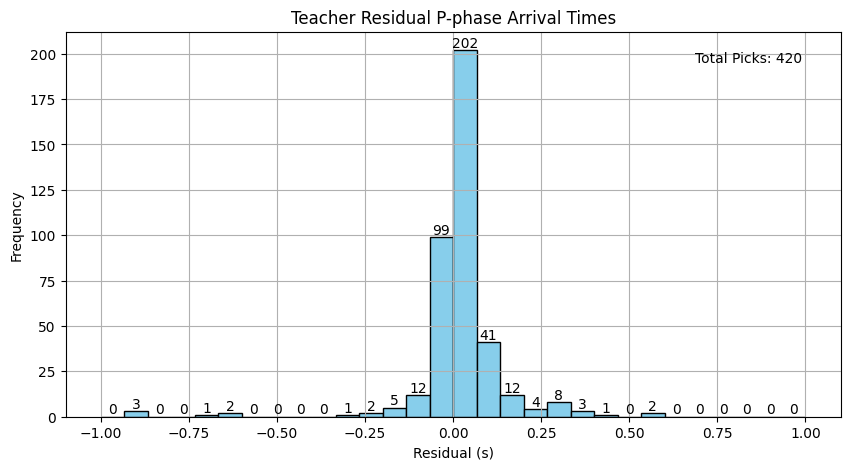

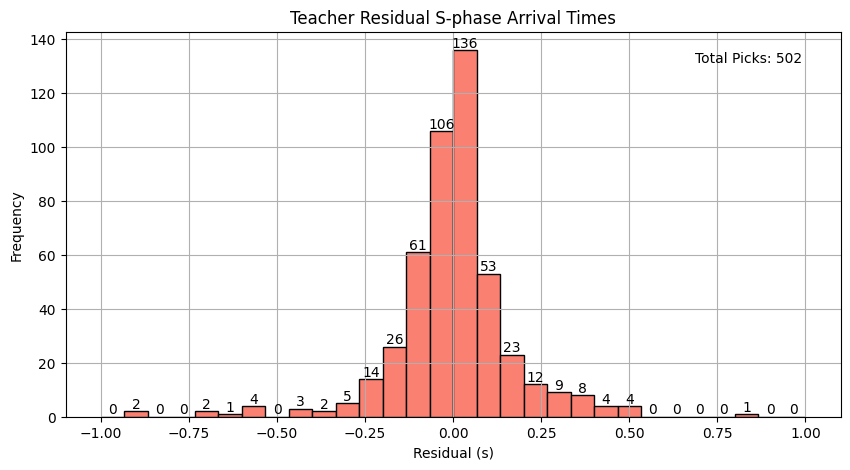


=== Student Residual Evaluation ===
Ground truth P peaks: 1316, S peaks: 1282
P residuals under 0.6s: 547
S residuals under 0.6s: 838
P residuals: mean=0.0479s, std=0.1280s, total=552
S residuals: mean=0.0100s, std=0.8898s, total=866


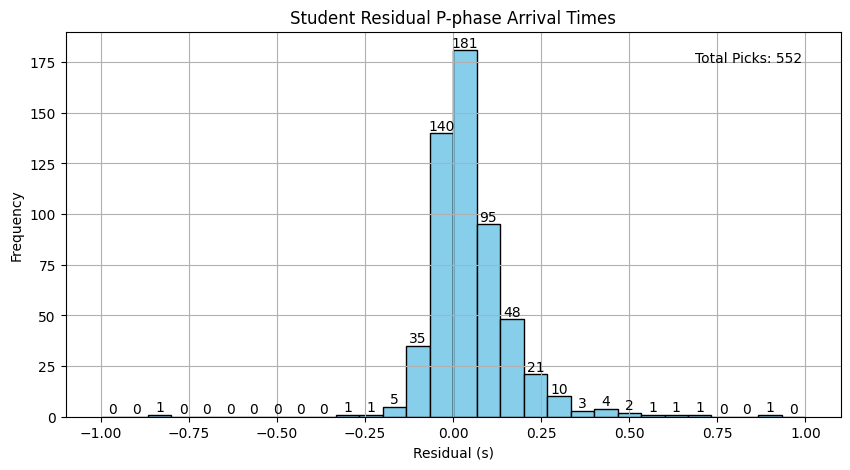

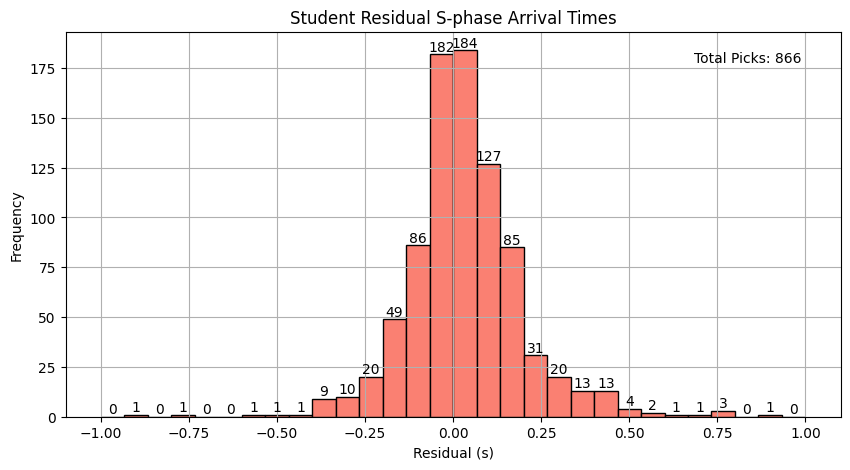


=== Teacher vs Student Summary ===
P-phase residuals under 0.6s: Teacher=392, Student=547
S-phase residuals under 0.6s: Teacher=470, Student=838
P-phase mean residual (s): Teacher=0.1501, Student=0.0479
P-phase std residual (s): Teacher=1.8150, Student=0.1280
S-phase mean residual (s): Teacher=-0.4037, Student=0.0100
S-phase std residual (s): Teacher=2.9702, Student=0.8898


In [38]:
# ------------------------------
# Residual-Based Evaluation Call
# ------------------------------

# Set evaluation parameters
height = 0.5           # Minimum peak probability
distance = 100         # Minimum peak separation (samples)
sampling_rate = 100    # Hz
tolerance = 0.6        # Seconds for residual threshold
n_samples = len(dev_generator)  # Evaluate all samples

# Evaluate Teacher Model
teacher_results = evaluate_model_residuals(
    model=teacher_model,
    data_generator=dev_generator,
    device=device,
    height=height,
    distance=distance,
    sampling_rate=sampling_rate,
    tolerance=tolerance,
    n_samples=n_samples,
    model_name="Teacher"
)

# Evaluate Student Model
student_results = evaluate_model_residuals(
    model=student_model,
    data_generator=dev_generator,
    device=device,
    height=height,
    distance=distance,
    sampling_rate=sampling_rate,
    tolerance=tolerance,
    n_samples=n_samples,
    model_name="Student"
)

# ------------------------------
# Compare Teacher vs Student
# ------------------------------

print("\n=== Teacher vs Student Summary ===")
print(f"P-phase residuals under {tolerance}s: Teacher={teacher_results['count_p_under_tol']}, Student={student_results['count_p_under_tol']}")
print(f"S-phase residuals under {tolerance}s: Teacher={teacher_results['count_s_under_tol']}, Student={student_results['count_s_under_tol']}")
print(f"P-phase mean residual (s): Teacher={teacher_results['mean_p']:.4f}, Student={student_results['mean_p']:.4f}")
print(f"P-phase std residual (s): Teacher={teacher_results['std_p']:.4f}, Student={student_results['std_p']:.4f}")
print(f"S-phase mean residual (s): Teacher={teacher_results['mean_s']:.4f}, Student={student_results['mean_s']:.4f}")
print(f"S-phase std residual (s): Teacher={teacher_results['std_s']:.4f}, Student={student_results['std_s']:.4f}")


In [39]:
import time

def evaluate_model_residuals_with_time(model, data_generator, device, 
                                       height=0.5, distance=100, sampling_rate=100,
                                       tolerance=0.6, n_samples=None, model_name="Model"):
    """
    Evaluate seismic phase picking model with residuals and measure inference time.
    
    Returns:
        dict with residuals, counts, mean/std, tolerance counts, and avg inference time
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    import torch

    model.eval()
    
    if n_samples is None:
        n_samples = len(data_generator)
    
    all_residual_p_arrival_times = []
    all_residual_s_arrival_times = []
    
    groundtruth_p_peaks = 0
    groundtruth_s_peaks = 0
    count_residuals_p_under_tol = 0
    count_residuals_s_under_tol = 0
    inference_times = []

    for _ in range(n_samples):
        sample = data_generator[np.random.randint(len(data_generator))]
        X_tensor = torch.tensor(sample["X"], device=device).unsqueeze(0)

        # Ground truth peaks
        y_p_peaks, _ = find_peaks(sample["y"][0], height=height, distance=distance)
        y_s_peaks, _ = find_peaks(sample["y"][1], height=height, distance=distance)
        groundtruth_p_peaks += len(y_p_peaks)
        groundtruth_s_peaks += len(y_s_peaks)
        y_p_times = y_p_peaks / sampling_rate
        y_s_times = y_s_peaks / sampling_rate

        # Model prediction with timing
        start_time = time.time()
        with torch.no_grad():
            pred = model(X_tensor)[0].cpu().numpy()
        end_time = time.time()
        inference_times.append(end_time - start_time)

        # Predicted peaks
        p_prob = pred[0]
        s_prob = pred[1]
        p_peaks, _ = find_peaks(p_prob, height=height, distance=distance)
        s_peaks, _ = find_peaks(s_prob, height=height, distance=distance)
        p_times = p_peaks / sampling_rate
        s_times = s_peaks / sampling_rate

        # Residuals: smallest absolute difference per ground truth peak
        for y_p_time in y_p_times:
            residuals = p_times - y_p_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_p_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_p_under_tol += 1
        for y_s_time in y_s_times:
            residuals = s_times - y_s_time
            if len(residuals) > 0:
                min_res = residuals[np.argmin(np.abs(residuals))]
                all_residual_s_arrival_times.append(min_res)
                if np.abs(min_res) < tolerance:
                    count_residuals_s_under_tol += 1

    # Compute statistics
    all_residual_p_arrival_times = np.array(all_residual_p_arrival_times)
    all_residual_s_arrival_times = np.array(all_residual_s_arrival_times)
    mean_p = np.mean(all_residual_p_arrival_times)
    std_p = np.std(all_residual_p_arrival_times)
    mean_s = np.mean(all_residual_s_arrival_times)
    std_s = np.std(all_residual_s_arrival_times)
    avg_inference_time = np.mean(inference_times)
    std_inference_time = np.std(inference_times)

    # Print summary
    print(f"\n=== {model_name} Residual Evaluation ===")
    print(f"Ground truth P peaks: {groundtruth_p_peaks}, S peaks: {groundtruth_s_peaks}")
    print(f"P residuals under {tolerance}s: {count_residuals_p_under_tol}")
    print(f"S residuals under {tolerance}s: {count_residuals_s_under_tol}")
    print(f"P residuals: mean={mean_p:.4f}s, std={std_p:.4f}s, total={len(all_residual_p_arrival_times)}")
    print(f"S residuals: mean={mean_s:.4f}s, std={std_s:.4f}s, total={len(all_residual_s_arrival_times)}")
    print(f"Avg inference time per sample: {avg_inference_time*1000:.2f} ms ± {std_inference_time*1000:.2f} ms")

    # Plot histograms
    def plot_hist(residuals, phase_name, color, filename):
        plt.figure(figsize=(10,5))
        counts, bins, patches = plt.hist(residuals, bins=30, color=color, edgecolor='black', range=(-1, 1))
        for count, bin_, patch in zip(counts, bins, patches):
            plt.text(bin_ + (bins[1]-bins[0])/2, count, f'{int(count)}', ha='center', va='bottom')
        plt.text(0.95, 0.95, f'Total Picks: {len(residuals)}', ha='right', va='top', transform=plt.gca().transAxes)
        plt.title(f'{model_name} Residual {phase_name} Arrival Times')
        plt.xlabel('Residual (s)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(filename)
        plt.show()

    plot_hist(all_residual_p_arrival_times, 'P-phase', 'skyblue', f"{model_name}_residual_p_hist.png")
    plot_hist(all_residual_s_arrival_times, 'S-phase', 'salmon', f"{model_name}_residual_s_hist.png")

    results = {
        'model_name': model_name,
        'residuals_p': all_residual_p_arrival_times,
        'residuals_s': all_residual_s_arrival_times,
        'count_p_under_tol': count_residuals_p_under_tol,
        'count_s_under_tol': count_residuals_s_under_tol,
        'mean_p': mean_p,
        'std_p': std_p,
        'mean_s': mean_s,
        'std_s': std_s,
        'groundtruth_p_peaks': groundtruth_p_peaks,
        'groundtruth_s_peaks': groundtruth_s_peaks,
        'avg_inference_time': avg_inference_time,
        'std_inference_time': std_inference_time
    }

    return results



=== Teacher (PhaseNet) Residual Evaluation ===
Ground truth P peaks: 762, S peaks: 731
P residuals under 0.6s: 212
S residuals under 0.6s: 280
P residuals: mean=0.2622s, std=1.6260s, total=229
S residuals: mean=-0.3449s, std=2.5569s, total=298
Avg inference time per sample: 3.78 ms ± 0.78 ms


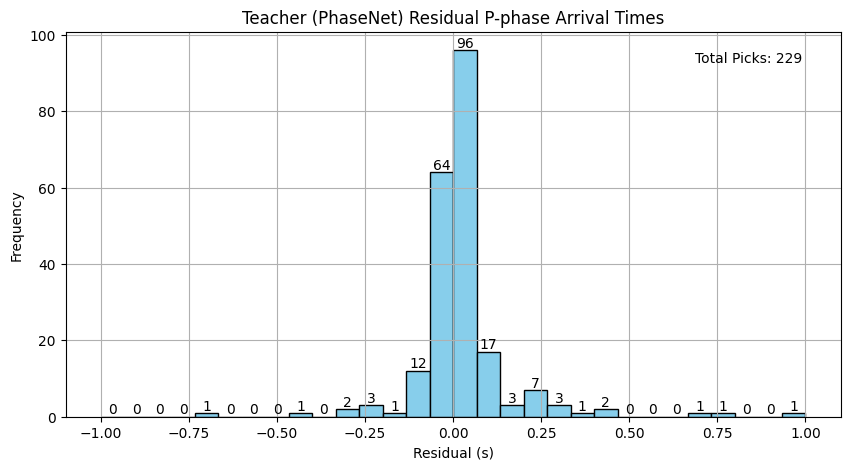

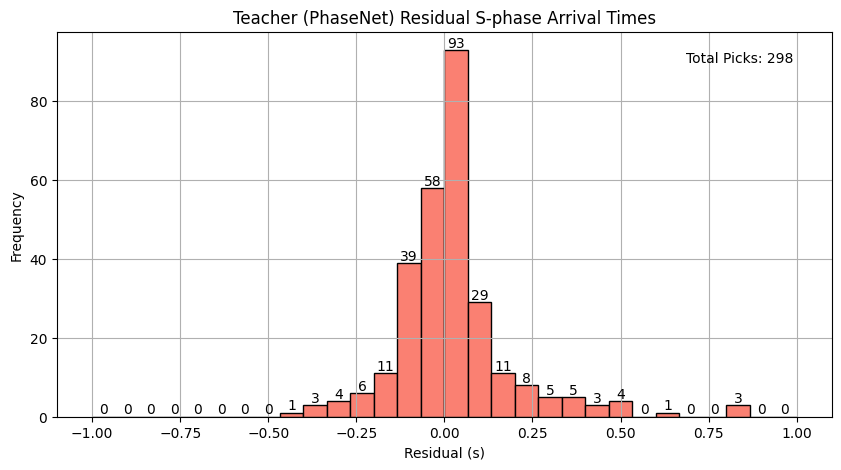


=== Student (XiaoNet) Residual Evaluation ===
Ground truth P peaks: 770, S peaks: 739
P residuals under 0.6s: 306
S residuals under 0.6s: 464
P residuals: mean=-0.0820s, std=1.7350s, total=314
S residuals: mean=0.0010s, std=1.1971s, total=480
Avg inference time per sample: 2.40 ms ± 0.66 ms


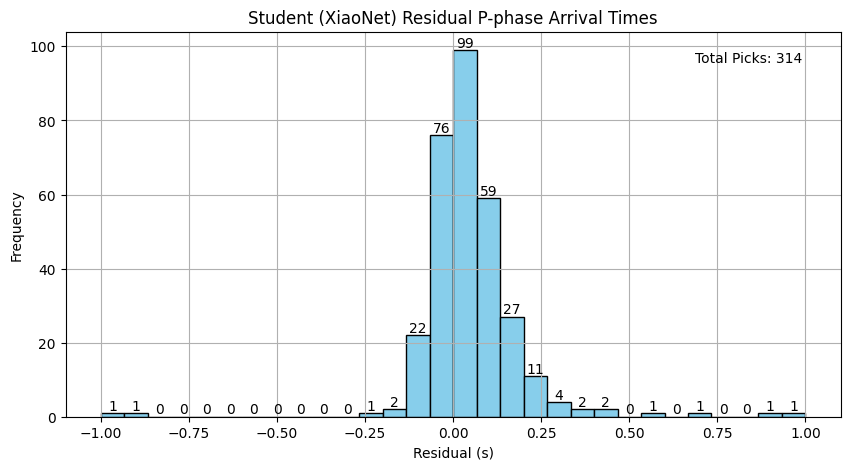

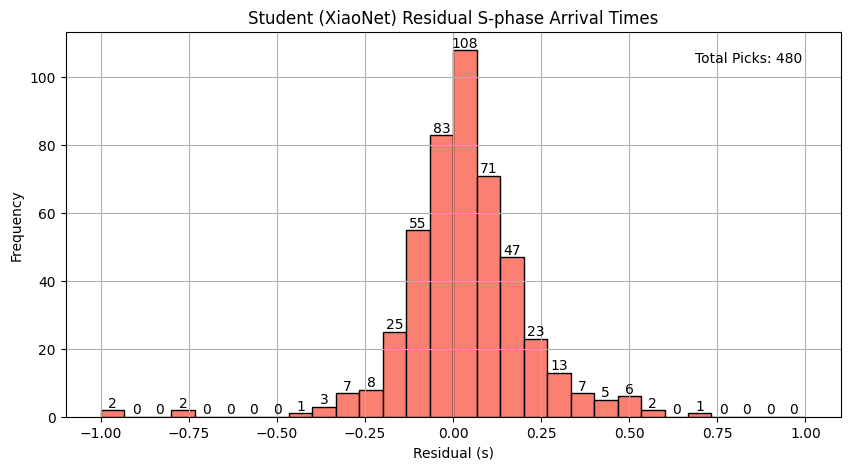


✅ Teacher vs Student Model Comparison
Metric                              | Teacher              | Student             
----------------------------------------------------------------------
Ground truth P peaks                |                  762 |                  770
Ground truth S peaks                |                  731 |                  739
P residuals under 0.6s              |                  212 |                  306
S residuals under 0.6s              |                  280 |                  464
P residuals mean ± std (s)          | 0.2622 ± 1.6260 | -0.0820 ± 1.7350
S residuals mean ± std (s)          | -0.3449 ± 2.5569 | 0.0010 ± 1.1971
Avg inference time per sample (ms)  | 3.78 ± 0.78 | 2.40 ± 0.66
Student vs Teacher Speedup          | -                    | 1.58x faster


In [40]:
# ------------------------------
# Evaluate Teacher Model
# ------------------------------
teacher_results = evaluate_model_residuals_with_time(
    model=teacher_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # or None for full dataset
    model_name="Teacher (PhaseNet)"
)

# ------------------------------
# Evaluate Student Model
# ------------------------------
student_results = evaluate_model_residuals_with_time(
    model=student_model,
    data_generator=dev_generator,
    device=device,
    height=0.5,
    distance=100,
    sampling_rate=100,
    tolerance=0.6,
    n_samples=1000,  # keep same number of samples for fair comparison
    model_name="Student (XiaoNet)"
)

# ------------------------------
# Compute Speedup
# ------------------------------
speedup = teacher_results['avg_inference_time'] / student_results['avg_inference_time']

# ------------------------------
# Print Full Comparison Table
# ------------------------------
print("\n" + "="*70)
print("✅ Teacher vs Student Model Comparison")
print("="*70)
print(f"{'Metric':35} | {'Teacher':20} | {'Student':20}")
print("-"*70)
print(f"{'Ground truth P peaks':35} | {teacher_results['groundtruth_p_peaks']:20} | {student_results['groundtruth_p_peaks']:20}")
print(f"{'Ground truth S peaks':35} | {teacher_results['groundtruth_s_peaks']:20} | {student_results['groundtruth_s_peaks']:20}")
print(f"{'P residuals under 0.6s':35} | {teacher_results['count_p_under_tol']:20} | {student_results['count_p_under_tol']:20}")
print(f"{'S residuals under 0.6s':35} | {teacher_results['count_s_under_tol']:20} | {student_results['count_s_under_tol']:20}")
print(f"{'P residuals mean ± std (s)':35} | {teacher_results['mean_p']:.4f} ± {teacher_results['std_p']:.4f} | {student_results['mean_p']:.4f} ± {student_results['std_p']:.4f}")
print(f"{'S residuals mean ± std (s)':35} | {teacher_results['mean_s']:.4f} ± {teacher_results['std_s']:.4f} | {student_results['mean_s']:.4f} ± {student_results['std_s']:.4f}")
print(f"{'Avg inference time per sample (ms)':35} | {teacher_results['avg_inference_time']*1000:.2f} ± {teacher_results['std_inference_time']*1000:.2f} | {student_results['avg_inference_time']*1000:.2f} ± {student_results['std_inference_time']*1000:.2f}")
print(f"{'Student vs Teacher Speedup':35} | {'-':20} | {speedup:.2f}x faster")
print("="*70)
